# kNN & Clustering

__Суммарное количество баллов: 10 + 3 bonus__

## kNN, рак и спам

В этом части домашнего задания Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from copy import deepcopy
from sklearn.neighbors import KDTree


### Задание 1 (1 балл)

#### 1. (0.5 балла)
Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`.

In [14]:
CANCER_DATA_PATH = "hw2_data/cancer.csv"
SPAM_DATA_PATH = "hw2_data/spam.csv"

In [15]:
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    data = pd.read_csv(path_to_csv)
    return data.drop("label", axis=1), data["label"].replace({"M":1, "B":0})

def read_spam_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    data = pd.read_csv(path_to_csv)
    
    return data.drop("label", axis=1), data["label"]

In [16]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

#### 2. (0.5 балла) 

Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

In [17]:
def train_test_split(X, y, ratio=0.9):
    X = X.sample(frac=1)
    y = y.iloc[X.index]
    n = int(ratio * len(X))
    return X[:n], y[:n], X[n:], y[n:]

### Задание 2 (1.5 балла)

Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [18]:
def get_precision_recall_accuracy(y_pred, y_true):
    # Возвращает precision, recall и accuracy
    # precision - набор значений метрики precision для каждого класса
    # recall - набор значений метрики recall для каждого класса
    # accuracy - число, отражающее общую точность предсказания
    n = len(y_true)
    n_classes = max(y_true) + 1
    true_positive = [0 for _ in range(n_classes)]
    false_positive, false_negative = deepcopy(true_positive), deepcopy(true_positive)
    
    for predicted, true in zip(y_pred, y_true):
        if predicted == true:
            true_positive[true] += 1
        else:
            false_positive[predicted] += 1
            false_negative[true] +=1
            
    precision = []
    recall = []
    accuracy = []
    for cls in range(n_classes):
        tp = true_positive[cls]
        fp = false_positive[cls]
        fn = false_negative[cls]
        precision.append(tp / (fp + tp))
        recall.append(tp / (fn + tp))
        accuracy.append((n - fp - fn) / n)
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [19]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [20]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
        
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 3  (3 балла)


## 1. (2 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [257]:
class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.kd = None
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
    
    def fit(self, X, y):
        self.classes = y_test.unique()
        self.kd = KDTree(X.to_numpy(), self.leaf_size)
        self.y = y.to_numpy()
        
    def predict_proba(self, X):
        X = X.to_numpy()
        X = X.reshape(1, -1) if len(X.shape) == 1 else X
        distance, indexs = self.kd.query(X, self.n_neighbors)
        
        X_proba = np.zeros((len(X), len(self.classes)))
        for label in self.classes:
            X_proba[:, label] = (self.y[indexs] == label).sum(axis=1)
            
        return X_proba / self.n_neighbors
            
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

Наконец, протестируем наш классификатор на различных наборах данных

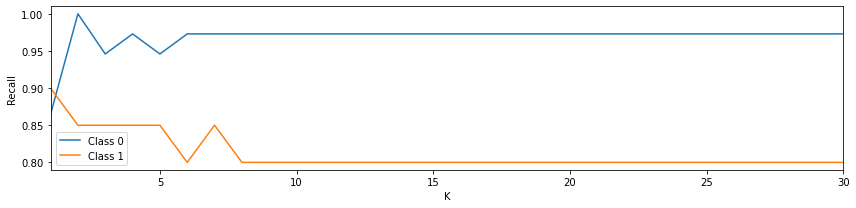

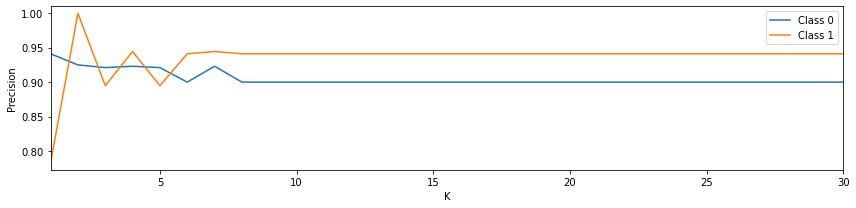

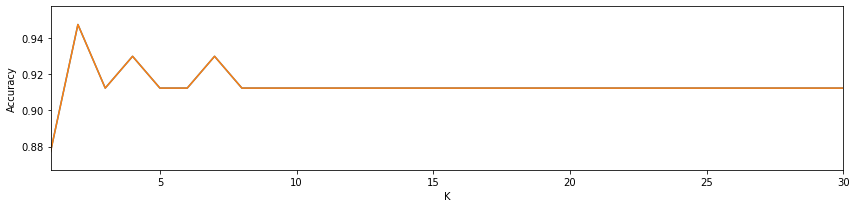

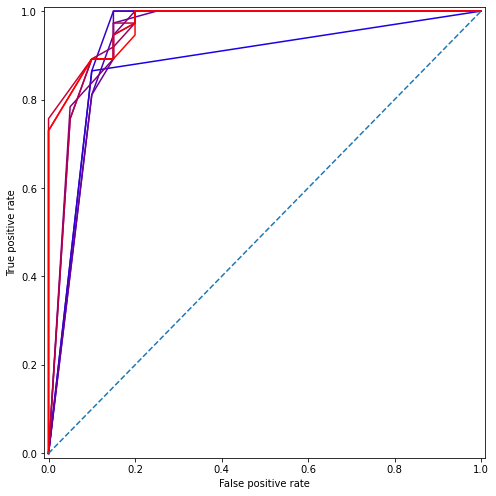

In [258]:
X_train, y_train, X_test, y_test = train_test_split(X_cancer, y_cancer, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

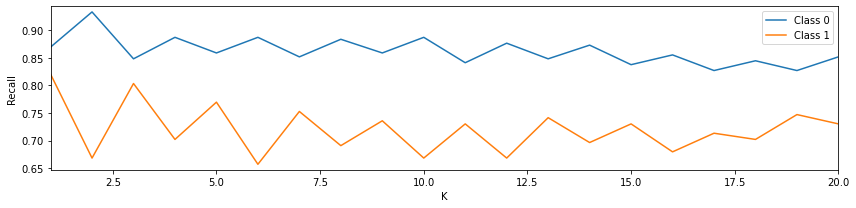

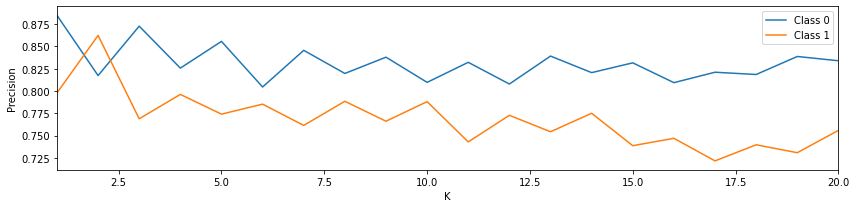

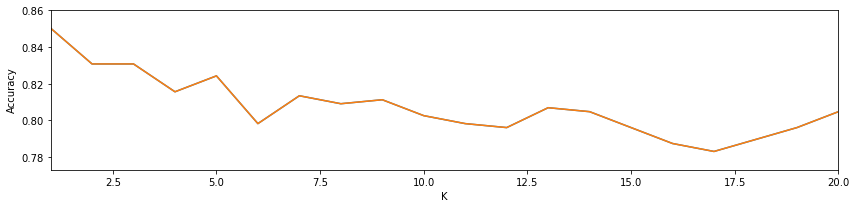

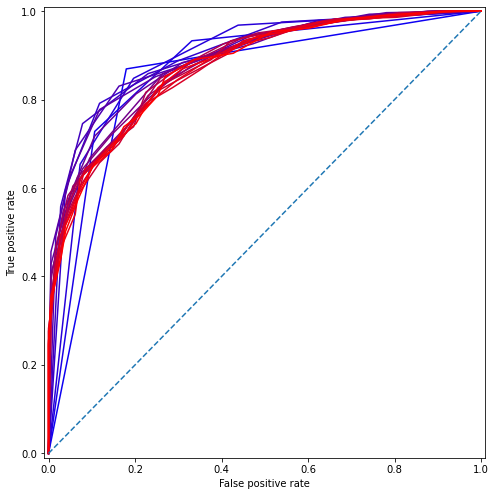

In [259]:
X_train, y_train, X_test, y_test = train_test_split(X_spam, y_spam, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)

#### 2. (1.5 балла)

Проанализируйте полученные графики. Какой параметр `k` кажется лучшим для каждой из задач? Какая из метрик лучше всего отражает качество модели? 

In [299]:
from sklearn.metrics import roc_auc_score as roc

def get_best_k(X, y, max_k):
    X_train, y_train, X_test, y_test = train_test_split(X, y, 0.7)
    rocs = []
    for i in range(1, max_k):
        kn = KNearest(i)
        kn.fit(X_train, y_train)
        p_pred = np.array([p for p in kn.predict_proba(X_test)])
        rocs.append(roc(y_test.to_numpy(), p_pred[:,1]))
    return np.argmax(rocs) + 1

print(f"The best k for cancer - {get_best_k(X_cancer, y_cancer, 10)}")
print(f"The best k for spam - {get_best_k(X_spam, y_spam, 20)}")

# I extend X_test for better estimation k.
# We have a non-balanced class, I would be choice roc auc metric

The best k for cancer - 9
The best k for spam - 6


## Clustering

В этой части домашнего задания предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [321]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from collections import deque

In [322]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

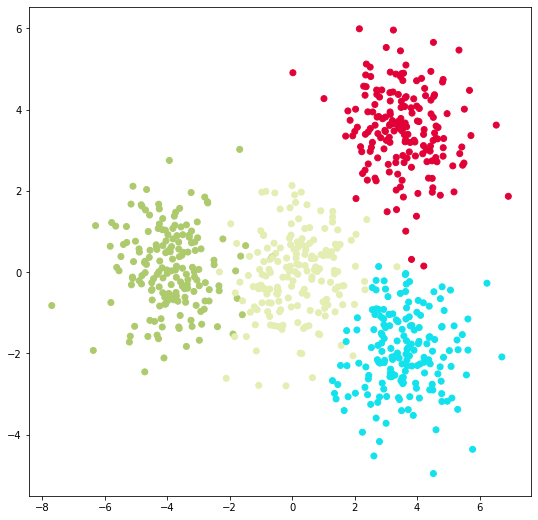

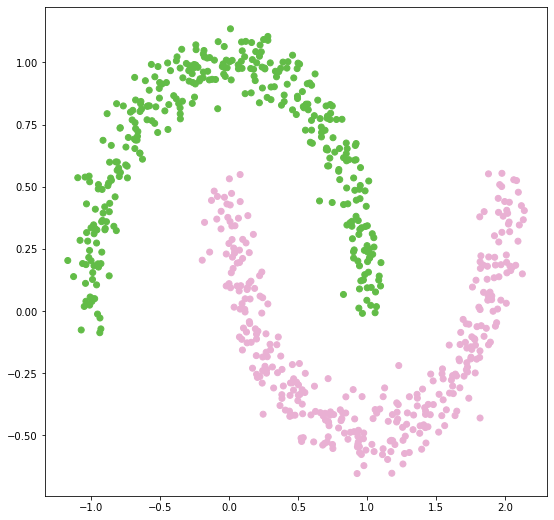

In [364]:
X_1, true_labels = make_blobs(700, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(700, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 4 (1.5 балла)

Первый метод, который предлагается реализовать - метод K средних.

__Описание методов__

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

__Инициализация кластеров__

Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [365]:
from numpy.linalg import norm
from numpy.random import random

class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        self.centroids = None
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.init = init
        
    def fit(self, X, y=None):
        #init
        if self.init == "random":
            size = (self.n_clusters, X.shape[1])
            a, b =  np.min(X, axis=0), np.max(X, axis=0)
            self.centroids = (b - a) * random(size) + a
        elif self.init == "sample":
            self.centroids = X[np.random.choice(len(X), self.n_clusters, replace=False)]
        elif self.init == "k-means++":
            self.centroids = self.kmpp(X)
        
        # alrogithms steps
        S = np.zeros(len(X))
        for _ in range(self.max_iter):
            for i in range(len(X)):
                S[i] = np.argmin([norm(X[i] - center) for center in self.centroids])

            for i in range(len(self.centroids)):
                ind = np.where(S == i)[0]
                self.centroids[i] = X[ind].mean(axis=0)
        
    def predict(self, X):
        S = np.zeros(len(X), dtype=int)
        for i in range(len(X)):
            S[i] = np.argmin([norm(X[i] - center, 2) for center in self.centroids], axis=0)
        return S
    
    def kmpp(self, X):
        idx = np.random.randint(len(X), size=1)
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        centroids[0] = X[idx]
        
        for i in range(1, self.n_clusters):
            distances = np.array([min([norm(c-x) for c in centroids[:i]]) for x in X])
            p = distances ** 2
            new_idx = np.random.choice(len(X), p=p / np.sum(p))
            centroids[i] = X[new_idx]
        return centroids

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

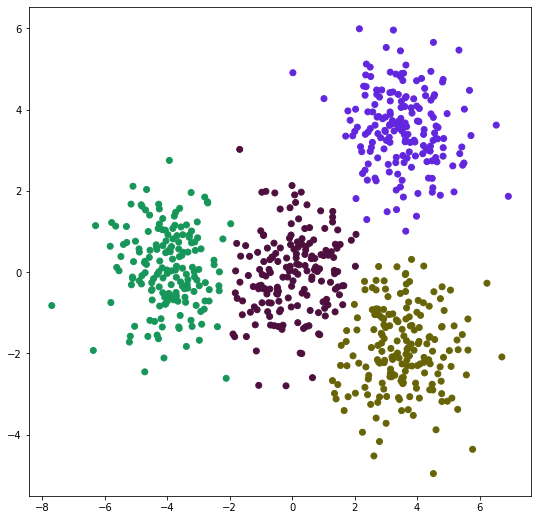

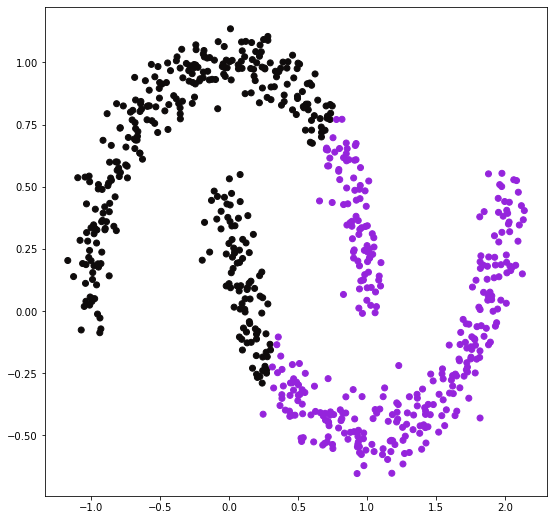

In [366]:
kmeans = KMeans(n_clusters=4, init="k-means++")
kmeans.fit(X_1)
labels11 = kmeans.predict(X_1)
visualize_clasters(X_1, labels11)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels12 = kmeans.predict(X_2)
visualize_clasters(X_2, labels12)

### Задание 5 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Возможные метрики__

* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [417]:
class Node:
    """Represents an element of a set."""
    def __init__(self, id):
        self.id = id
        self.parent = self
        self.rank = 0
        self.size = 1

    def __repr__(self):
        return 'Node({!r})'.format(self.id)


def Find(x):
    """Returns the representative object of the set containing x."""
    if x.parent is not x:
        x.parent = Find(x.parent)
    return x.parent


def Union(x, y):
    """Combines the sets x and y belong to."""
    xroot = Find(x)
    yroot = Find(y)

    # x and y are already in the same set
    if xroot is yroot:
        return

    # x and y are not in same set, so we merge them
    if xroot.rank < yroot.rank:
        xroot, yroot = yroot, xroot  # swap xroot and yroot

    # merge yroot into xroot
    yroot.parent = xroot
    xroot.size += yroot.size
    if xroot.rank == yroot.rank:
        xroot.rank = xroot.rank + 1

In [430]:
from sklearn.preprocessing import LabelEncoder

class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.metric = metric
        self.leaf_size = leaf_size
        
    def fit_predict(self, X, y=None):
        self.X = X
        self.kd = KDTree(X, self.leaf_size)

        # creating KD
        self.kd = KDTree(X, self.leaf_size, self.metric)

        # creating system of disjoint sets
        self.clasters = list(map(Node, [i for i in range(len(X))]))     
        self.without_class = {i for i in range(len(X))}
        self.new_points = {0}
        
        wc_on_prev = 0
        
        # when we have at without class only noise stop
        while len(self.without_class) != wc_on_prev:
            for_remove = set()
            wc_on_prev = len(self.without_class)
            
            # processing new_points
            for point in list(self.new_points):
                self.update_new_points(point)
                for_remove.add(point)
                
            self.new_points -= for_remove

            # processing without_class
            if len(self.new_points) == 0:
                # getting id without class
                for point in list(self.without_class):
                    self.update_new_points(point)
                    if len(self.new_points) != 0:
                        continue
                        
        labels = np.array([Find(claster).id for claster in self.clasters])
        labels[list(self.without_class)] = -1
        labels = LabelEncoder().fit_transform(labels)
        return labels
                    
    
    def update_new_points(self, point):
        indexes = self.kd.query_radius(self.X[point].reshape(1, -1), 
                                                 self.eps)
        # if count points more then min samples
        if len(indexes[0]) >= self.min_samples:
            for index in indexes[0]:
                if index in self.without_class:          
                    self.without_class.remove(index)
                    self.new_points.add(index)
                    
                Union(self.clasters[point], self.clasters[index])

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

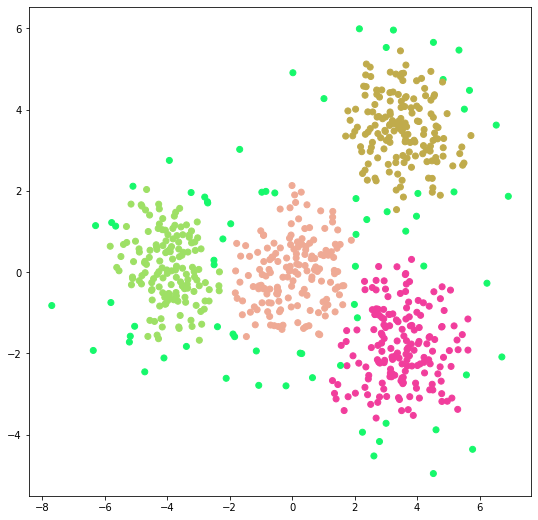

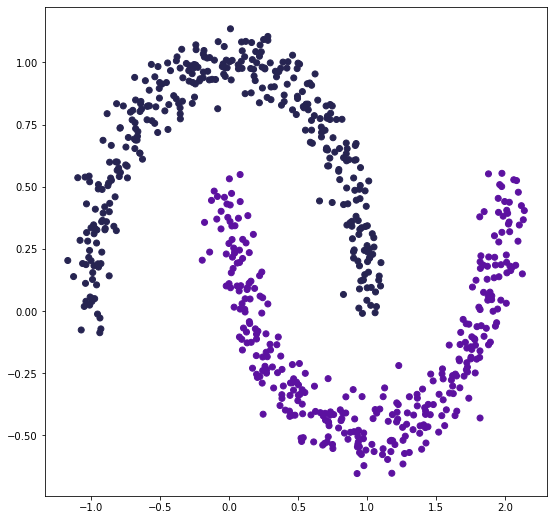

Время, затраченное на выполнение данного кода =  0.6658320426940918


In [428]:
import time
startTime = time.time()

dbscan = DBScan(eps=0.45, min_samples=5)
labels21 = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels21)

dbscan = DBScan(eps=0.14, min_samples=4)
labels22 = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels22)

endTime = time.time() #время конца замера
totalTime = endTime - startTime #вычисляем затраченное время

print("Время, затраченное на выполнение данного кода = ", totalTime)

### Задание 6 (0.5 балла)

Проанализируйте полученные результаты. 

Какой метод лучше справился с кластеризацией каждого из датасетов? Почему? 

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для определения качества кластеризации. 

Какие значения метрики свидетельствуют о хорошей кластеризации - большие или маленькие?

Зрительно knn лучше на 1 датасете, а dbscan на втором. Второй метод более гибкий, но на подбор параметров ушло какое-то время

In [431]:
from sklearn.metrics import davies_bouldin_score as dbs
from sklearn.metrics import silhouette_score as ss
# dbs(X_2[labels22 != 0], labels22[labels22 != 0])
labels22[labels22 != 0]

In [433]:
print(f'dsc for first dataset knn - {dbs(X_1, labels11)},',
      f'dbscan - {dbs(X_1[labels21 != 0], labels21[labels21 != 0])}')

print(f'dsc for second dataset knn - {dbs(X_2, labels12)},',
      f'dbscan - {dbs(X_2, labels22)}')

print(f'silhouette for first dataset knn - {ss(X_1, labels11)},',
      f'dbscan - {ss(X_1[labels21 != 0], labels21[labels21 != 0])}')

print(f'silhouette for second dataset knn - {ss(X_2, labels12)},',
      f'dbscan - {ss(X_2, labels22)}')


# Как и говорилось ранее, knn показывает похожий результат с dbscan на 
# первом датасете, причем кластеризует все точки. А dbs scan на втором, 
# потому что silhouette score предусматривет не кругообразоное расположение класстеров

dsc for first dataset knn - 0.5865219711918239, dbscan - 0.5362846820922699
dsc for second dataset knn - 0.7825738019298789, dbscan - 1.1664519901555594
silhouette for first dataset knn - 0.568426826516611, dbscan - 0.6101546886439325
silhouette for second dataset knn - 0.48628238306416244, dbscan - 0.3283202829437871
